In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
plt.style.use('Solarize_Light2')
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan
import math
import pickle


mpl.rcParams['figure.dpi'] = 150


In [2]:
blobs, labels = make_blobs(n_samples=2000, n_features=10) # 10 features
pd.DataFrame(blobs).head() # show the first 5 rows

clusterer = hdbscan.HDBSCAN()

def healpix(sourceID, level):
    pixel = math.floor(sourceID /(2**35 * 4**(12-level)))
    return pixel

def parallax(mas):
    arcsec = mas/1000
    return 1/arcsec


parallax(1.1)

healpix(3094113406614578432, 5)


5496

In [3]:
clusterer.fit(blobs) # do the clustering algorithm

#clusterer stores the results of the clusters in the labels_ attribute

clusterer.labels_ # show the labels of the clusters
# This gives an array of integers, where each integer is the cluster number of the corresponding row in the input data

cluster_amount = clusterer.labels_.max() +1 # number of clusters

cluster_amount
#data samples that are not assigned to a cluster get label -1   



3

In [4]:
membership_score = clusterer.probabilities_ # membership score of each data point to the cluster it is assigned to ranging from 0 to 1. 
# A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score)
# while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core).

membership_score

array([0.55922255, 0.82888551, 0.80653345, ..., 0.50765005, 0.79280044,
       0.72958858])

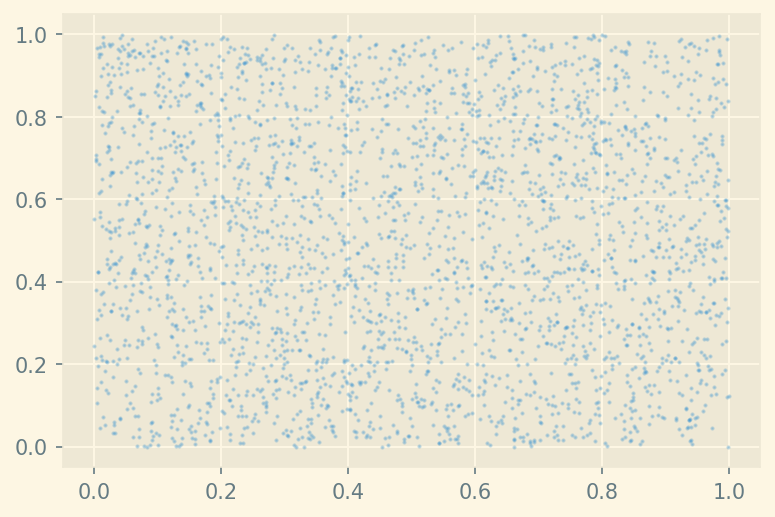

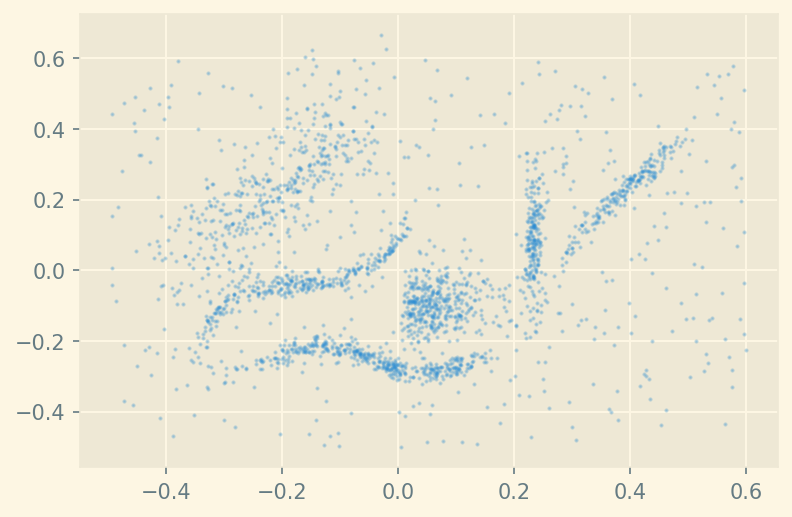

In [5]:
#//generate 3000 random datapoints in 2d

data = np.load('Data\\clusterable_data.npy')
randomdata = np.random.rand(3000,2)
plt.plot(randomdata[:,0], randomdata[:,1], 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()

plt.plot(*data.T, 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()


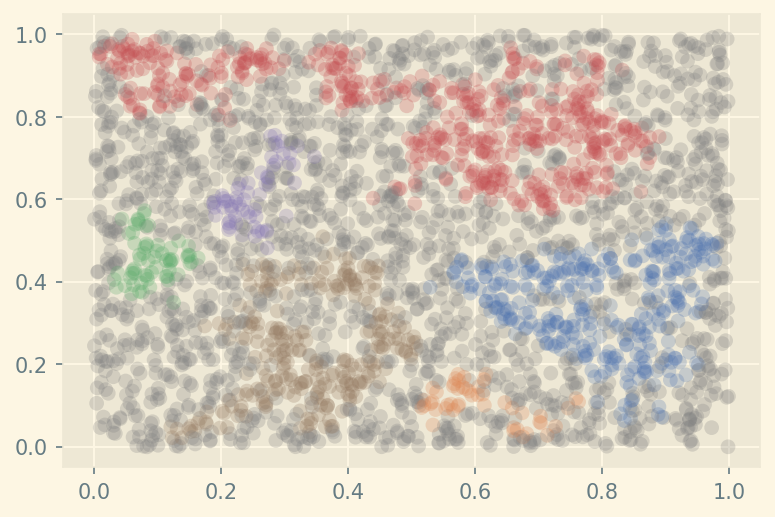

In [6]:

randclusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(randomdata)
color_palette = sns.color_palette('deep', 77)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in randclusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, randclusterer.probabilities_)]

plt.scatter(randomdata[:,0], randomdata[:,1], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)



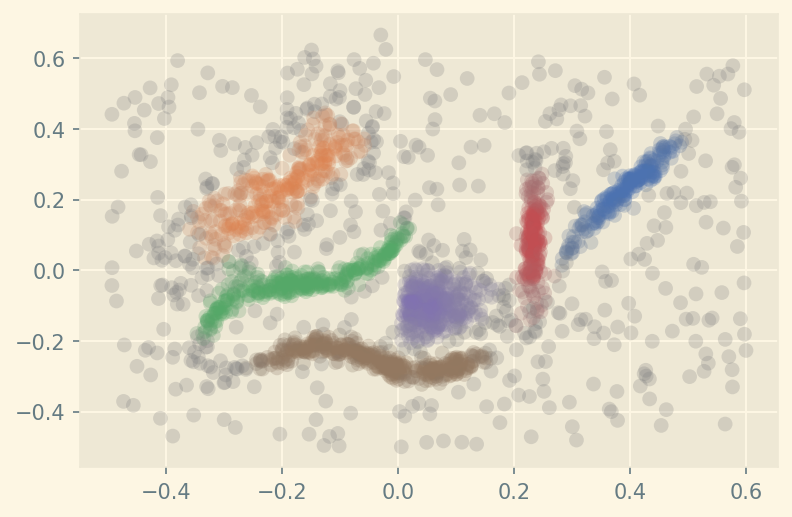

In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

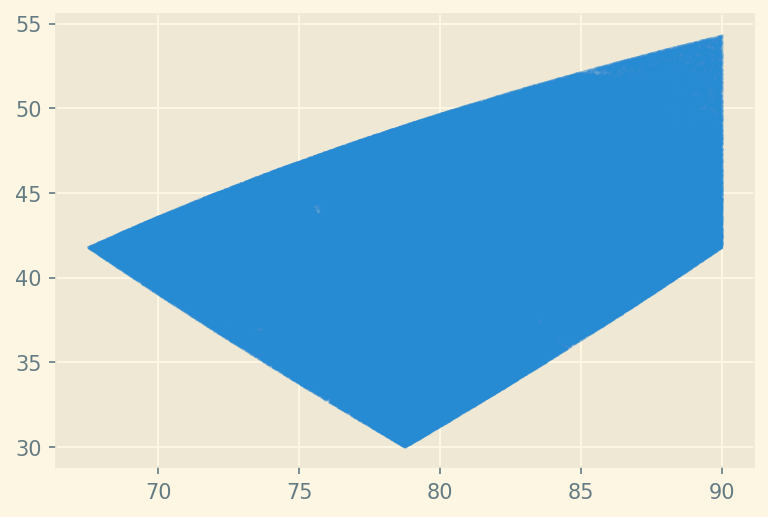

array(['COIN-Gaia_13', 'Platais_10', 'UBC_13', 'UBC_14', 'UBC_21',
       'UPK_495', 'UPK_533', 'UPK_654'], dtype=object)

In [8]:
coindata = pd.read_csv('Data\\COIN_results.csv')

members = pd.read_csv('Data\\inner_members.csv')
                                                
# coindata = coindata[coindata['phot_g_mean_mag'] <= 16]
 
plt.plot(coindata['ra'], coindata['dec'], 'o', markersize=0.1, alpha=0.25, linewidth = 0)
plt.show()
members['Cluster'].unique()

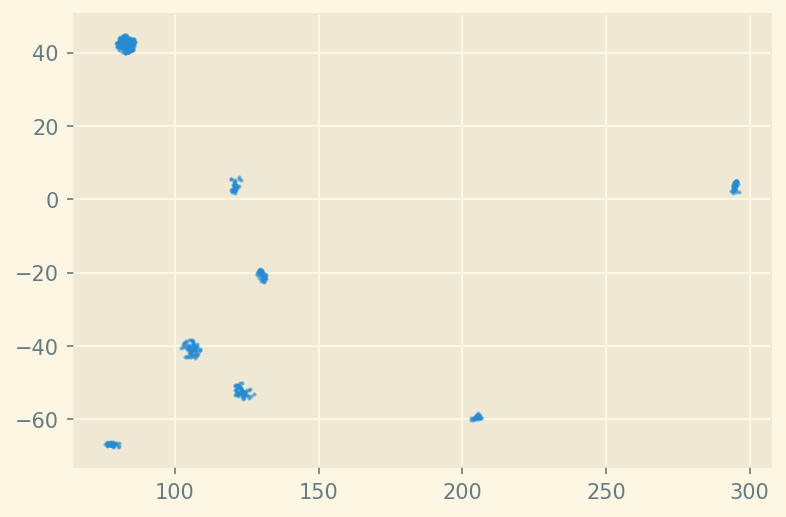

In [9]:

COINmembers = members[members['Cluster'] == 'COIN-Gaia_13']




In [15]:
# coincandidate = filtered_df.query('clusternumber ==4')
# len(coincandidate)

# plt.scatter(coincandidate['ra'], coincandidate['dec'], s=20, c='red', alpha=0.5)

#
''' so we find an overdensity which kind of corresponds with the cluster. how many conbtaminants do we find? change the magnitude limit, and see how it changes. 
more faint in magnitude, more diluted cluster, see at different magnitude to how many clusters the cluster is assigned to.
argument as completeness, purity and contamination. see if the purity of the cluster depends on density of stars (stars / square degree) i.e. the magnitude of the stars.'''

' so we find an overdensity which kind of corresponds with the cluster. how many conbtaminants do we find? change the magnitude limit, and see how it changes. \nmore faint in magnitude, more diluted cluster, see at different magnitude to how many clusters the cluster is assigned to.\nargument as completeness, purity and contamination. see if the purity of the cluster depends on density of stars (stars / square degree) i.e. the magnitude of the stars.'

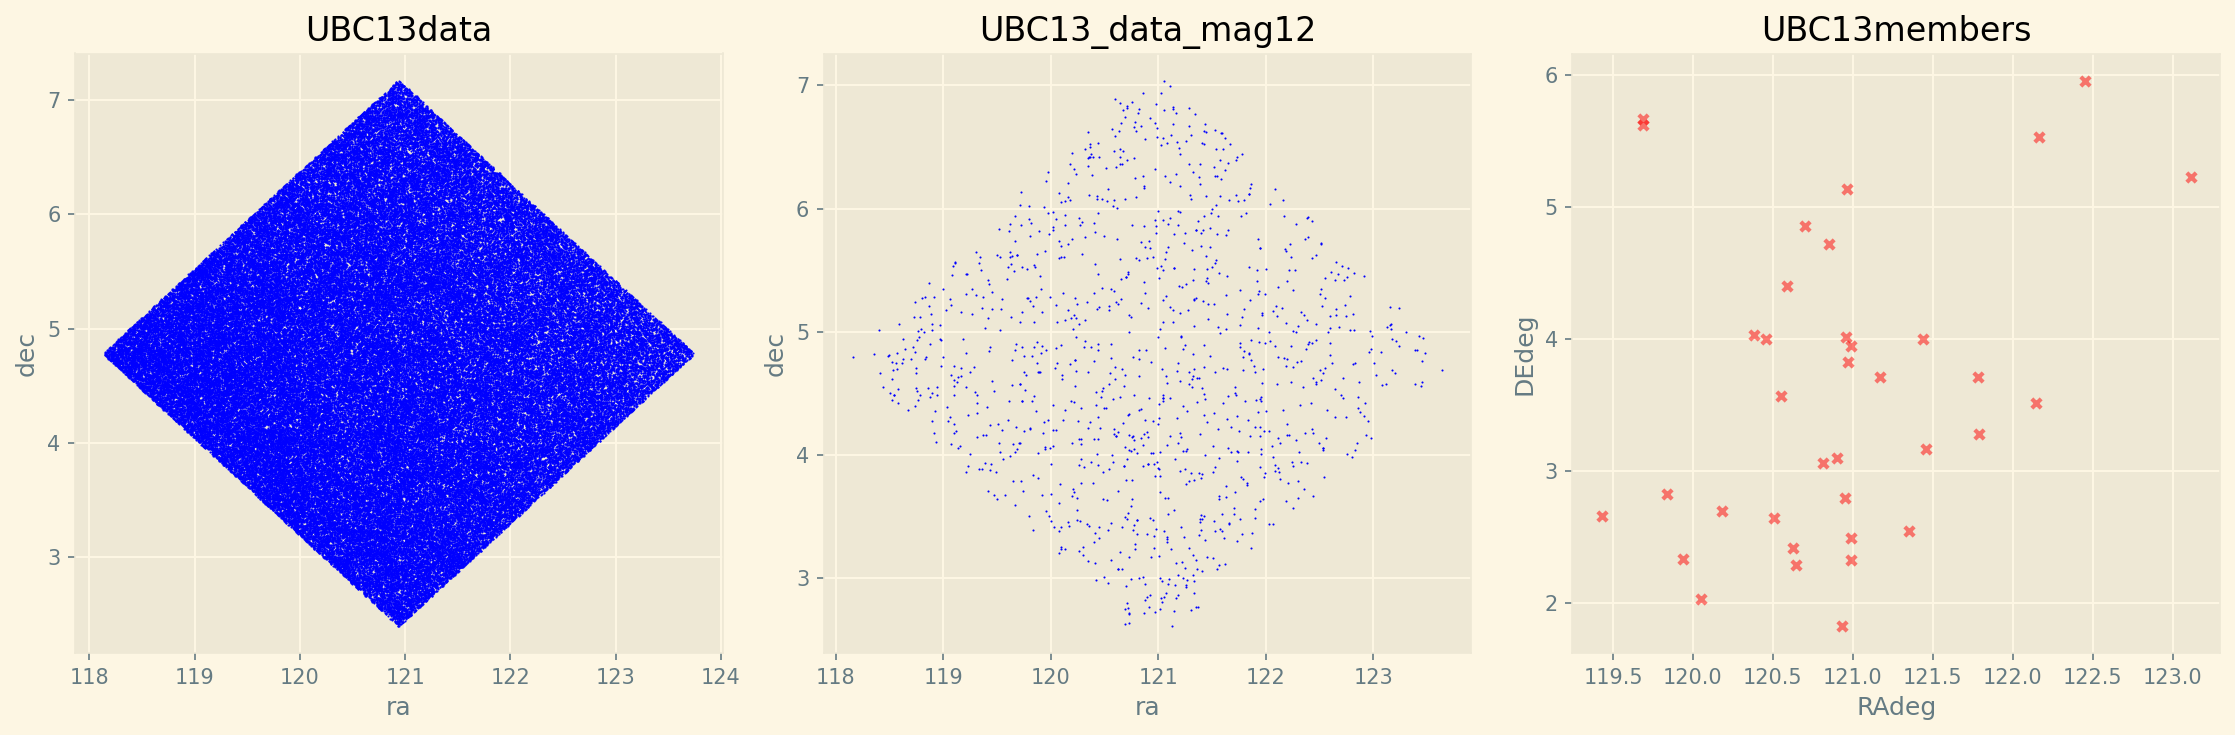

In [16]:
UBC13members = members[members['Cluster'] == 'UBC_13']
UBC13data = pd.read_csv('Data\\UBC13.csv')

UBC13_data_mag12 =UBC13data[UBC13data['phot_g_mean_mag'] <= 12]


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].scatter(UBC13data['ra'], UBC13data['dec'], s=1, linewidth=0, c='blue')
axs[0].set_title('UBC13data')
axs[0].set_xlabel('ra')
axs[0].set_ylabel('dec')

# Second subplot
axs[1].scatter(UBC13_data_mag12['ra'], UBC13_data_mag12['dec'], s=1, linewidth=0, c='blue')
axs[1].set_title('UBC13_data_mag12')
axs[1].set_xlabel('ra')
axs[1].set_ylabel('dec')

# Third subplot
axs[2].scatter(UBC13members['ra'], UBC13members['dec'],marker= 'x', s=20, c='red', alpha=0.5)
axs[2].set_title('UBC13members')
axs[2].set_xlabel('ra')
axs[2].set_ylabel('dec')

plt.tight_layout()
plt.show()




In [17]:
#cluster the data
UBC13needed = UBC13_data_mag12[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']]
UBC13needed = UBC13needed.dropna()

UBC13_cluster_prep = UBC13needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]


UBC13_clusters_mag12 = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method='leaf', min_samples=10).fit(UBC13_cluster_prep)

print(UBC13_clusters_mag12.labels_.max() + 1)

UBC13needed['clusternumber'] = UBC13_clusters_mag12.labels_ # add the cluster number to the dataframe


2


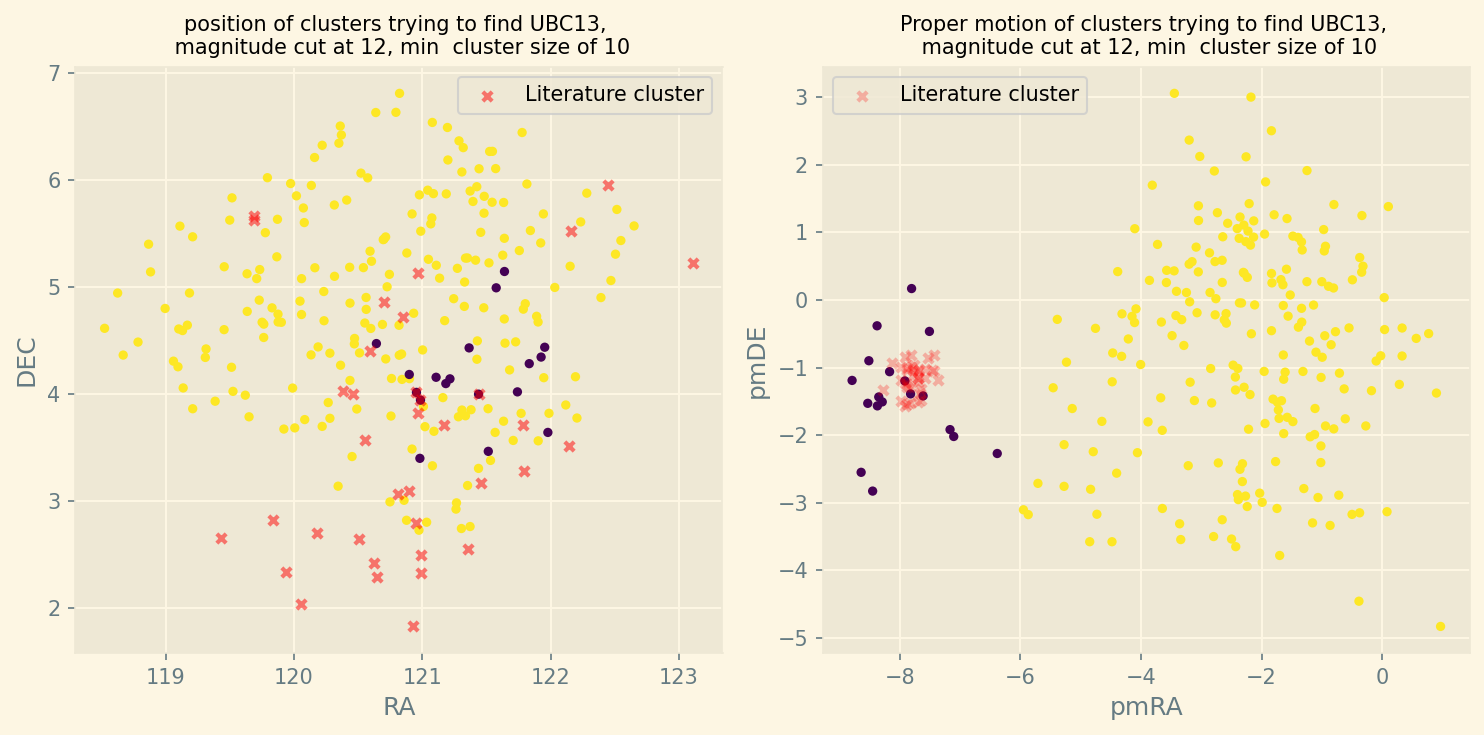

In [18]:
#plot the positions and proper motions of the clusters
indices_to_keep = np.where(UBC13_clusters_mag12.labels_ != -1)[0]
UBC13_clusters_mag12_isolated = UBC13needed.iloc[indices_to_keep]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13_clusters_mag12_isolated['ra'], UBC13_clusters_mag12_isolated['dec'], s=20, linewidth=0, c=UBC13_clusters_mag12.labels_[indices_to_keep])
axs[0].scatter(UBC13members['ra'], UBC13members['dec'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
axs[0].set_title('position of clusters trying to find UBC13, \n magnitude cut at 12, min  cluster size of 10', fontsize = 10)
axs[0].legend()
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

# Second subplot
axs[1].scatter(UBC13_clusters_mag12_isolated['pmra'], UBC13_clusters_mag12_isolated['pmdec'], s=20, linewidth=0, c=UBC13_clusters_mag12.labels_[indices_to_keep])
axs[1].scatter(UBC13members['pmra'], UBC13members['pmdec'],marker= 'x', s=20, c='red', alpha=0.25, label='Literature cluster')
axs[1].set_title('Proper motion of clusters trying to find UBC13, \n magnitude cut at 12, min  cluster size of 10', fontsize=10)
axs[1].legend()
axs[1].set_xlabel('pmra')
axs[1].set_ylabel('pmdec')

plt.tight_layout()
plt.savefig('Data\\UBC13_clusters_mag12.pdf')
plt.show()


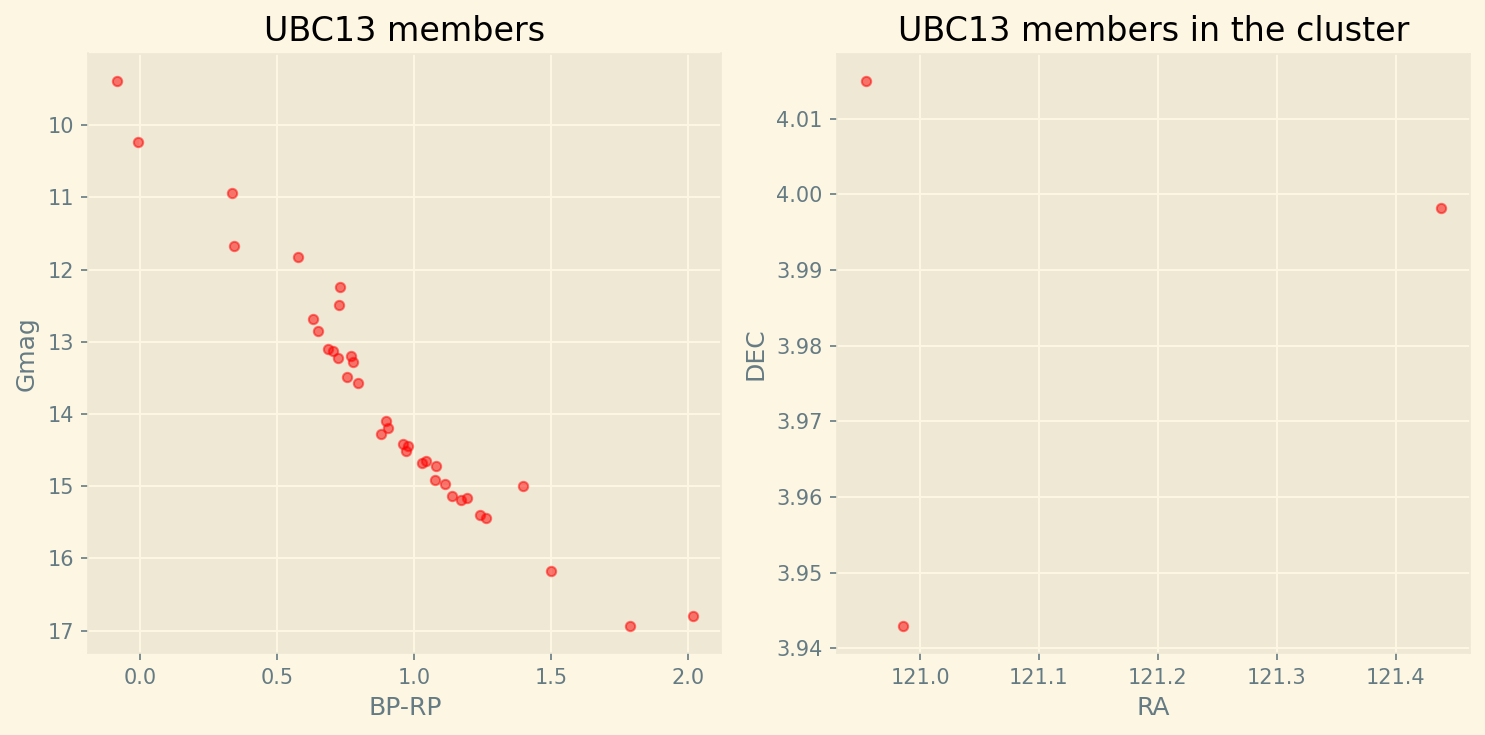

18
for UBC13, with a magnitude cut at 12, the purity is 0.16666666666666666 and the completeness is 0.08333333333333333


In [19]:
#find completeness and purity of the cluster

UBC13_merge_mag12 = pd.merge(UBC13members, UBC13_clusters_mag12_isolated, left_on='Source', right_on='source_id', how='inner')
UBC13_merge_mag12

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13members['BP-RP'], UBC13members['Gmag'], s=20, c='red', alpha=0.5)
axs[0].invert_yaxis()
axs[0].set_title('UBC13 members')
axs[0].set_xlabel('BP-RP')
axs[0].set_ylabel('Gmag')

# Second subplot
axs[1].scatter(UBC13_merge_mag12['ra'], UBC13_merge_mag12['dec'], s=20, c='red', alpha=0.5)
axs[1].set_title('UBC13 members in the cluster')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')

plt.tight_layout()
plt.show()

UBC13_candidates_mag12 = UBC13_clusters_mag12_isolated.query('clusternumber == 0')
print(len(UBC13_candidates_mag12))
UBC13_merge_mag12

UBC13_purity_mag12 = len(UBC13_merge_mag12) / len(UBC13_candidates_mag12)
UBC13_completeness_mag12 = len(UBC13_merge_mag12) / len(UBC13members)

print(f'for UBC13, with a magnitude cut at 12, the purity is {UBC13_purity_mag12} and the completeness is {UBC13_completeness_mag12}')




Now i will do the same thing for no magnitude cut as i dont have time to slowely increase the cut before the presentation.

In [20]:
#cluster the data
UBC13needed = UBC13data[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']]
UBC13needed = UBC13needed.dropna()

UBC13_cluster_prep = UBC13needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]


UBC13_clusters = hdbscan.HDBSCAN(min_cluster_size=20, cluster_selection_method='leaf', min_samples=10).fit(UBC13_cluster_prep)

print(UBC13_clusters.labels_.max() + 1)

UBC13needed['clusternumber'] = UBC13_clusters.labels_ # add the cluster number to the dataframe

40


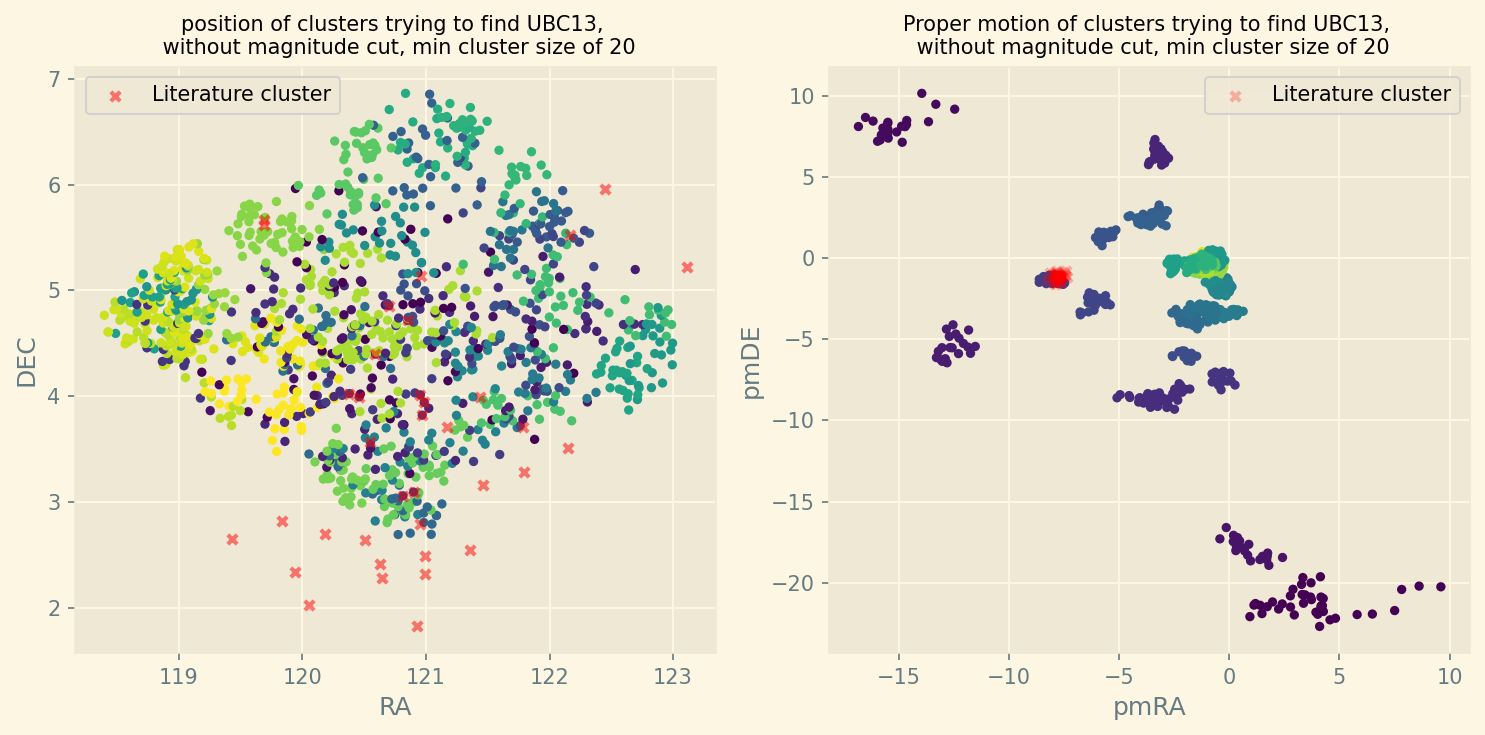

In [21]:
#plot the positions and proper motions of the clusters
indices_to_keep = np.where(UBC13_clusters.labels_ != -1)[0]
UBC13_clusters_isolated = UBC13needed.iloc[indices_to_keep]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13_clusters_isolated['ra'], UBC13_clusters_isolated['dec'], s=20, linewidth=0, c=UBC13_clusters.labels_[indices_to_keep])
axs[0].scatter(UBC13members['ra'], UBC13members['dec'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
axs[0].set_title('position of clusters trying to find UBC13, \n without magnitude cut, min cluster size of 20', fontsize = 10)
axs[0].legend()
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

# Second subplot
axs[1].scatter(UBC13_clusters_isolated['pmra'], UBC13_clusters_isolated['pmdec'], s=20, linewidth=0, c=UBC13_clusters.labels_[indices_to_keep])
axs[1].scatter(UBC13members['pmra'], UBC13members['pmdec'],marker= 'x', s=20, c='red', alpha=0.25, label='Literature cluster')
axs[1].set_title('Proper motion of clusters trying to find UBC13, \n without magnitude cut, min cluster size of 20', fontsize=10)
axs[1].legend()
axs[1].set_xlabel('pmra')
axs[1].set_ylabel('pmdec')

plt.tight_layout()
plt.savefig('Data\\UBC13_clusters.pdf')
plt.show()


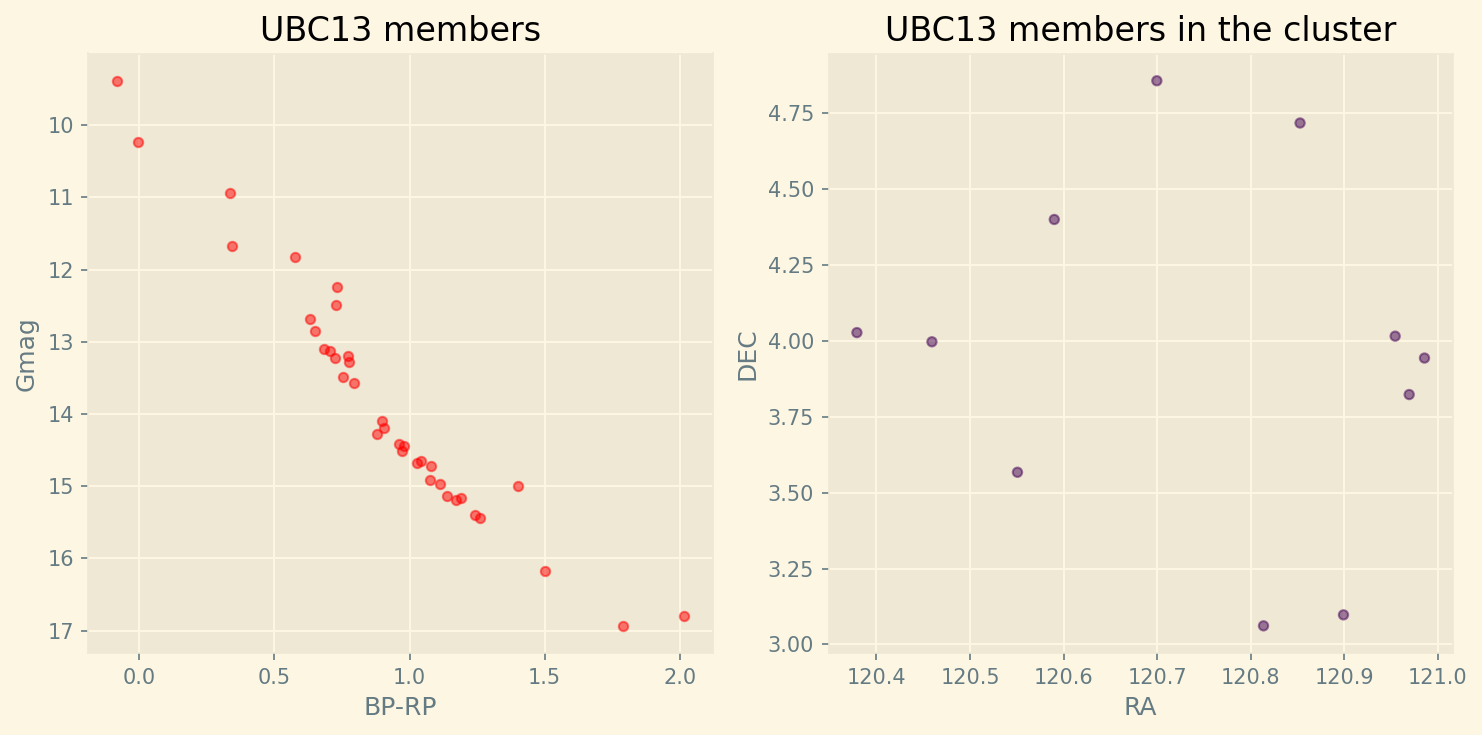

40
for UBC13, without a magnitude cut, the purity is 0.275 and the completeness is 0.3055555555555556


array([-1, 29, 12, 24, 27,  8,  3, 11, 15, 26,  4, 35,  1, 39,  2, 38,  7,
       14,  5,  6, 13,  0, 36, 17, 30, 37, 33, 34, 31, 10, 28, 19, 22, 16,
        9, 18, 20, 32, 23, 21, 25], dtype=int64)

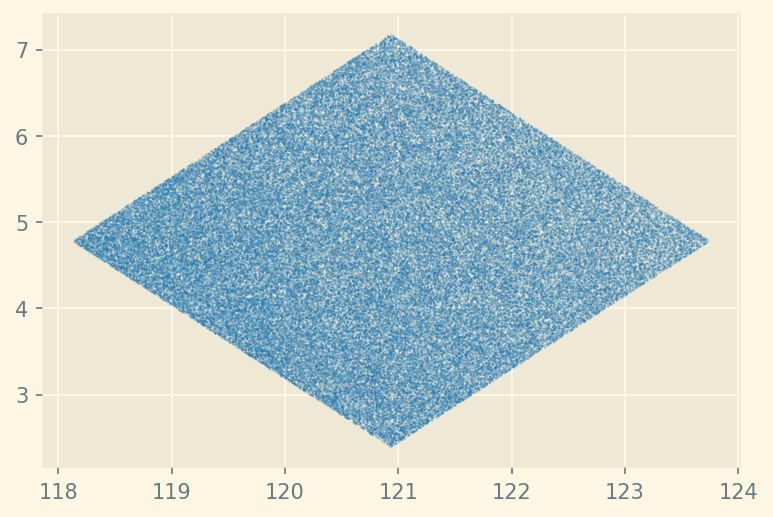

In [22]:
#find completeness and purity of the cluster

UBC13_merge = pd.merge(UBC13members, UBC13_clusters_isolated, left_on='Source', right_on='source_id', how='inner')
UBC13_merge

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13members['BP-RP'], UBC13members['Gmag'], s=20, c='red', alpha=0.5)
axs[0].invert_yaxis()
axs[0].set_title('UBC13 members')
axs[0].set_xlabel('BP-RP')
axs[0].set_ylabel('Gmag')

# Second subplot
axs[1].scatter(UBC13_merge['ra'], UBC13_merge['dec'], s=20, c= UBC13_merge['clusternumber'], alpha=0.5)
axs[1].set_title('UBC13 members in the cluster')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')

plt.tight_layout()
plt.show()

UBC13_candidates = UBC13_clusters_isolated.query('clusternumber == 0')
print(len(UBC13_candidates))
UBC13_merge

UBC13_purity = len(UBC13_merge) / len(UBC13_candidates)
UBC13_completeness = len(UBC13_merge) / len(UBC13members)

print(f'for UBC13, without a magnitude cut, the purity is {UBC13_purity} and the completeness is {UBC13_completeness}')

plt.scatter(UBC13needed['ra'], UBC13needed['dec'], s=1, alpha=0.25, linewidth = 0, c=UBC13needed['clusternumber'], cmap='tab10')
UBC13needed['clusternumber'].unique()

Now I will put all of this into a function


In [23]:
def HDBSCAN(data, minsize, magnitudecut):
    data = data[data['phot_g_mean_mag'] <= magnitudecut]
    data_needed = data[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']].dropna()
    HDBprep = data_needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize, cluster_selection_method='leaf', min_samples=10).fit(HDBprep)
    data_needed['clusternumber'] = clusterer.labels_
    clusteramount = clusterer.labels_.max() + 1
    print(f'HDBScan found {clusteramount} clusters at magnitudecut {magnitudecut}.')
    return data_needed, clusterer


In [1]:
def Clusteranalysis(data_needed, clusterer, literaturecluster, clustername, magnitudecut, minclustersize, savename):
    indices_to_keep = np.where(clusterer.labels_ != -1)[0] # find the indices of the clusters that are not noise
    isolatedclusters = data_needed.iloc[indices_to_keep] # change to the correct dataframe

    #plot the positions and proper motions of the clusters
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    #do the magnitude cut on the literaturecluster
    literaturecluster = literaturecluster[literaturecluster['Gmag'] <= magnitudecut]

    # First subplot
    axs[0].scatter(isolatedclusters['ra'], isolatedclusters['dec'], s=20, linewidth=0, c=clusterer.labels_[indices_to_keep])
    axs[0].scatter(literaturecluster['ra'], literaturecluster['dec'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
    axs[0].set_title(f'position of clusters trying to find {clustername}, \n with magnitude cut G = {magnitudecut}, min cluster size of {minclustersize}', fontsize = 10)
    axs[0].legend()
    axs[0].set_xlabel('RA')
    axs[0].set_ylabel('DEC')

    # Second subplot
    axs[1].scatter(isolatedclusters['pmra'], isolatedclusters['pmdec'], s=20, linewidth=0, c=clusterer.labels_[indices_to_keep])
    axs[1].scatter(literaturecluster['pmra'], literaturecluster['pmdec'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
    axs[1].set_title(f'Proper motion of clusters trying to find {clustername}, \n with magnitude cut G = {magnitudecut}, min cluster size of {minclustersize}', fontsize=10)
    axs[1].legend()
    axs[1].set_xlabel('pmra')
    axs[1].set_ylabel('pmdec')

    plt.tight_layout()
    plt.savefig(f'Data\\Plots\\{savename}.pdf')
    plt.close()

    #find completeness and purity of the cluster
    merge = pd.merge(literaturecluster, isolatedclusters, left_on='souce_id', right_on='source_id', how='inner') # merge the literature cluster with the clustered dataset on common source id to see which stars coincide
    print(f"The crossmatch finds {len(merge)} matches in cluster(s) {merge['clusternumber'].unique()}.")

    #plot the CMD and position of stars in the cluster matched with the dataset
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First subplot
    axs[0].scatter(literaturecluster['bp_rp'], literaturecluster['phot_g_mean_mag'], s=20, c='red', alpha=0.5)
    axs[0].invert_yaxis()
    axs[0].set_title(f'{clustername} members')
    axs[0].set_xlabel('BP-RP')
    axs[0].set_ylabel('Gmag')

    # Second subplot
    if len(merge) > 0:
        axs[1].scatter(merge['ra_x'], merge['dec_x'], s=20, c='red', alpha=0.5)
        axs[1].set_title(f'{clustername} members in the cluster')
        axs[1].set_xlabel('RA')
        axs[1].set_ylabel('DEC')

    plt.tight_layout()
    plt.savefig(f'Data\\Plots\\{savename}CMD.pdf')
    plt.close()
    if len(merge['clusternumber'].unique()) > 1:
        print(f'{clustername} has {len(literaturecluster)} members at magnitude cutoff {magnitudecut}and is assigned to multiple clusters, namely {merge["clusternumber"].unique()}.')
        members_per_cluster = np.array([]) # array to store the amount of members per cluster
        membersarray = np.array([]) # array to store the amount of members per cluster in the literature cluster
        
        completeness = len(merge) / len(literaturecluster)

        for i in merge['clusternumber'].unique():
            members_per_cluster = np.append(members_per_cluster,len(merge[merge["clusternumber"] == i]))
            localpurity = len(merge[merge["clusternumber"] == i]) / len(isolatedclusters[isolatedclusters["clusternumber"] == i])
            localcompleteness = len(merge[merge["clusternumber"] == i]) / len(literaturecluster)
            print(f'The Cluster {i} found using HDBscan with a size of {len(isolatedclusters[isolatedclusters["clusternumber"] == i])}, has {len(merge[merge["clusternumber"] == i])} crossmatched members. The completeness is {localcompleteness} and the purity is {localpurity}.')
            membersarray = np.append(membersarray, len(isolatedclusters[isolatedclusters["clusternumber"] == i]))
        purity = np.sum(members_per_cluster) / np.sum(membersarray)   
        return purity, completeness, np.sum(membersarray)

    elif len(merge) == 0:
        print('There are no matches found.')
        candidates = 0
        purity = 0
        completeness = 0
        return purity, completeness, candidates
        
    else:
        unique_cluster = merge["clusternumber"].unique()[0]
        candidates = isolatedclusters.query(f'clusternumber == {unique_cluster}') # get all the stars in the clustered dataset that are in the same cluster as the literature cluster
        print(f'The cluster found using HDBSCAN has {len(candidates)} members. The literature cluster has {len(literaturecluster)} members.')

        purity = len(merge) / len(candidates)
        completeness = len(merge) / len(literaturecluster)
        print(f'for {clustername}, with a magnitude cut at {magnitudecut}, the purity is {purity} and the completeness is {completeness}')
    return purity, completeness, len(candidates)
    

'We should compare to the dr3 version of the inner members. '

'We should compare to the dr3 version of the inner members. '

In [25]:
UBC13_mag13_needed, UBC13_mag13_clusterer = HDBSCAN(UBC13data, 20, 13)

Clusteranalysis(UBC13_mag13_needed, UBC13_mag13_clusterer, UBC13members, 'UBC13', 16, 20, 'UBC13_clusters_mag16')


HDBScan found 2 clusters at magnitudecut 13.
The crossmatch finds 4 matches in cluster(s) [1].
The cluster found using HDBSCAN has 28 members. The literature cluster has 36 members.
for UBC13, with a magnitude cut at 16, the purity is 0.14285714285714285 and the completeness is 0.1111111111111111


In [26]:
COIN_mag13_needed, COIN_mag13_clusterer = HDBSCAN(coindata, 20, 13)

Clusteranalysis(COIN_mag13_needed, COIN_mag13_clusterer, COINmembers, 'COIN-Gaia_15', 15, 20, 'COIN_clusters_mag15')

HDBScan found 55 clusters at magnitudecut 13.
The crossmatch finds 37 matches in cluster(s) [2].
The cluster found using HDBSCAN has 42 members. The literature cluster has 311 members.
for COIN-Gaia_15, with a magnitude cut at 15, the purity is 0.8809523809523809 and the completeness is 0.1189710610932476


In [27]:

# #automate
# #create dictionary
# COIN_dictionary = {}
# COIN_cluster_dict = {}
# for i in np.arange(12, 21):
#     COIN_dictionary[f"COIN_mag{i}_needed"], COIN_cluster_dict[f"COIN_mag{i}_clusterer"] = HDBSCAN(coindata, 10, i)




In [81]:
#create dictionaries
UBC13_dictionary = {}
UBC13_cluster_dict = {}

magnitudecuts = np.arange(12, 21)

for i in magnitudecuts:
    clustersize = min(10, len(UBC13members.query(f'Gmag <= {i}')))
    UBC13_dictionary[f'UBC13_mag{i}_needed'], UBC13_cluster_dict[f'UBC13_mag{i}_clusterer'] = HDBSCAN(UBC13data, clustersize, i)

#save the dictionaries as csv files 
for key in UBC13_dictionary.keys():
    UBC13_dictionary[key].to_csv(f'Data\\UBC13\\needed\\{key}.csv', index=False)
for key in UBC13_cluster_dict.keys():
    with open(f'Data\\UBC13\\clusterer\\{key}.pkl', 'wb') as f:
        pickle.dump(UBC13_cluster_dict[key], f)


HDBScan found 4 clusters at magnitudecut 12.
HDBScan found 7 clusters at magnitudecut 13.
HDBScan found 9 clusters at magnitudecut 14.
HDBScan found 12 clusters at magnitudecut 15.
HDBScan found 35 clusters at magnitudecut 16.
HDBScan found 49 clusters at magnitudecut 17.
HDBScan found 75 clusters at magnitudecut 18.
HDBScan found 112 clusters at magnitudecut 19.
HDBScan found 174 clusters at magnitudecut 20.


In [82]:
#create a loop over the dictionaries to do the cluster analysis
UBC13_purity_values = np.array([])
UBC13_completeness_values = np.array([])
UBC13_cluster_sizes = np.array([])


for i in magnitudecuts:


    purity, completeness, HDBcluster_size = Clusteranalysis(UBC13_dictionary[f'UBC13_mag{i}_needed'], UBC13_cluster_dict[f'UBC13_mag{i}_clusterer'], UBC13members, 'UBC13', i, clustersize, f'UBC13_clusters_mag{i}')
    UBC13_purity_values = np.append(UBC13_purity_values, purity)
    UBC13_completeness_values = np.append(UBC13_completeness_values, completeness)
    UBC13_cluster_sizes = np.append(UBC13_cluster_sizes, HDBcluster_size)

'look at the provided paper to see how to deal with multiple clusters'

The crossmatch finds 3 matches in cluster(s) [1].
The cluster found using HDBSCAN has 18 members. The literature cluster has 5 members.
for UBC13, with a magnitude cut at 12, the purity is 0.16666666666666666 and the completeness is 0.6
The crossmatch finds 4 matches in cluster(s) [4].
The cluster found using HDBSCAN has 28 members. The literature cluster has 9 members.
for UBC13, with a magnitude cut at 13, the purity is 0.14285714285714285 and the completeness is 0.4444444444444444
The crossmatch finds 8 matches in cluster(s) [2].
The cluster found using HDBSCAN has 23 members. The literature cluster has 16 members.
for UBC13, with a magnitude cut at 14, the purity is 0.34782608695652173 and the completeness is 0.5
The crossmatch finds 13 matches in cluster(s) [1].
The cluster found using HDBSCAN has 35 members. The literature cluster has 28 members.
for UBC13, with a magnitude cut at 15, the purity is 0.37142857142857144 and the completeness is 0.4642857142857143
The crossmatch find

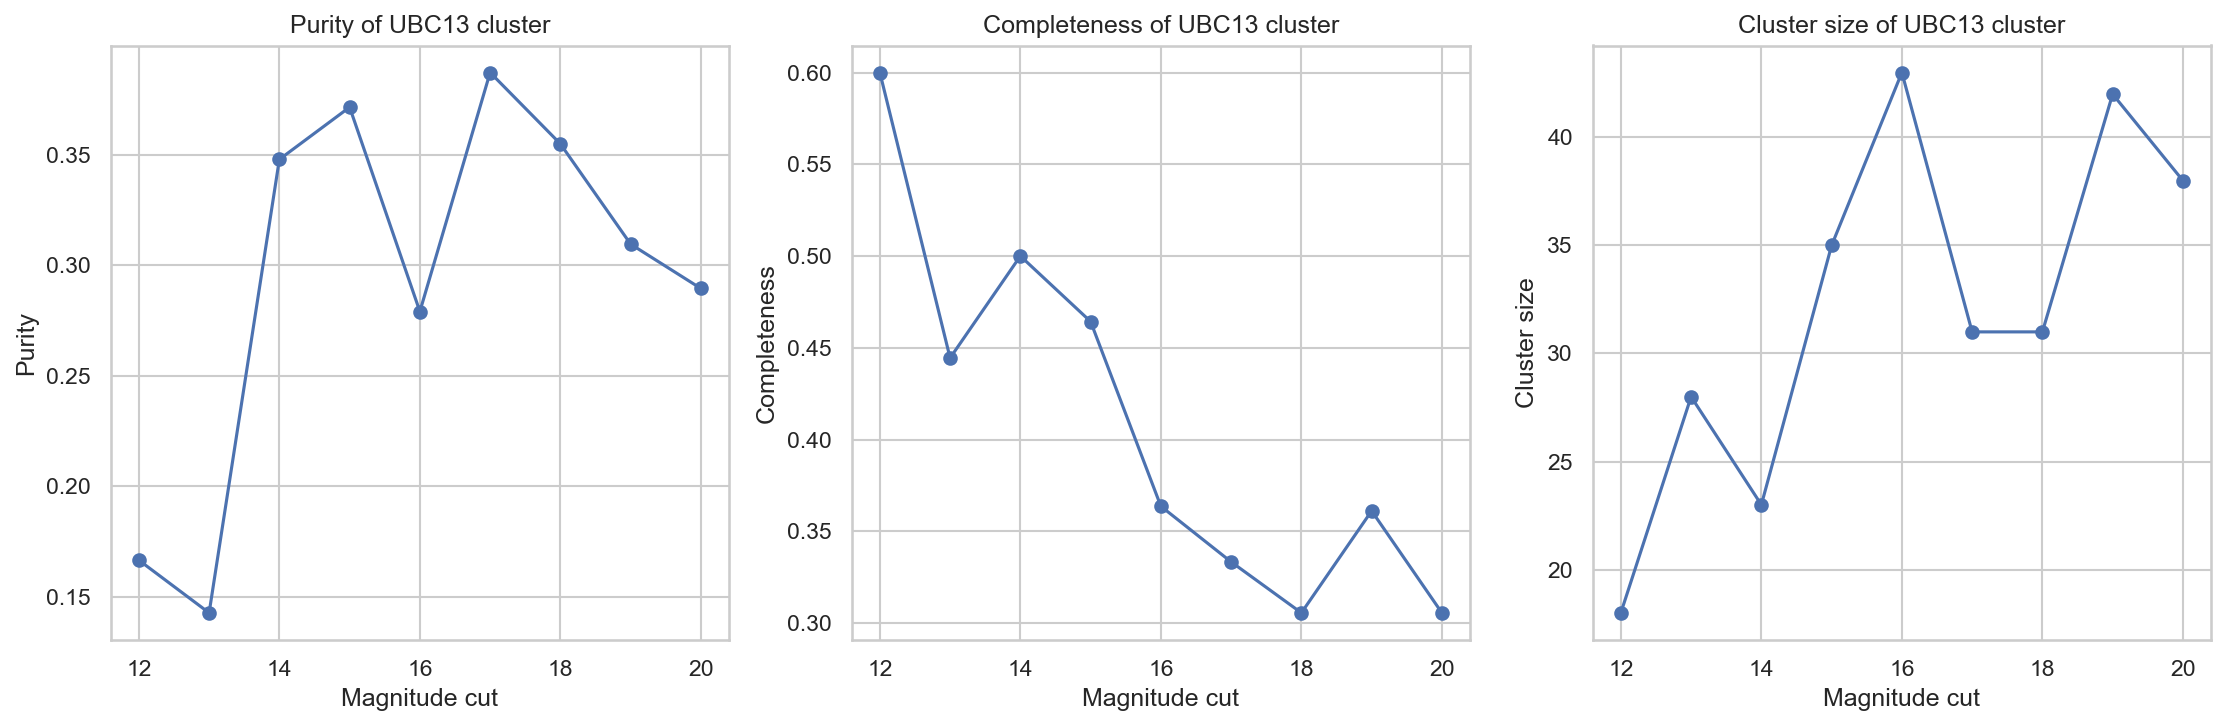

In [83]:
#plot the purity values, completeness values and cluster sizes against the magnitude cut

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].plot(magnitudecuts, UBC13_purity_values, marker='o')
axs[0].set_xlabel('Magnitude cut')
axs[0].set_ylabel('Purity')
axs[0].set_title('Purity of UBC13 cluster')

# Second subplot
axs[1].plot(magnitudecuts, UBC13_completeness_values, marker='o')
axs[1].set_xlabel('Magnitude cut')
axs[1].set_ylabel('Completeness')
axs[1].set_title('Completeness of UBC13 cluster')

# Third subplot
axs[2].plot(magnitudecuts, UBC13_cluster_sizes, marker='o')
axs[2].set_xlabel('Magnitude cut')
axs[2].set_ylabel('Cluster size')
axs[2].set_title('Cluster size of UBC13 cluster')

plt.tight_layout()
plt.show()



In [84]:
#now UBC21 (130.455, -20.747) 5703436468502273152
healpix(5703436468502273152, 4)
UBC21_members = members[members['Cluster'] == 'UBC_21']
UBC21_data = pd.read_csv('Data\\UBC21.csv')

UBC21_dictionary = {}
UBC21_cluster_dict = {}

for i in magnitudecuts:
    clustersize = min(10, len(UBC21_members.query(f'Gmag <= {i}')))
    UBC21_dictionary[f'UBC21_mag{i}_needed'], UBC21_cluster_dict[f'UBC21_mag{i}_clusterer'] = HDBSCAN(UBC21_data, clustersize, i)

#save the dictionaries as csv files
for key in UBC21_dictionary.keys():
    UBC21_dictionary[key].to_csv(f'Data\\UBC21\\needed\\{key}.csv', index=False)
    
for key in UBC21_cluster_dict.keys():
    with open(f'Data\\UBC21\\clusterer\\{key}.pkl', 'wb') as f:
        pickle.dump(UBC21_cluster_dict[key], f)


HDBScan found 13 clusters at magnitudecut 12.
HDBScan found 4 clusters at magnitudecut 13.
HDBScan found 8 clusters at magnitudecut 14.
HDBScan found 29 clusters at magnitudecut 15.
HDBScan found 55 clusters at magnitudecut 16.
HDBScan found 101 clusters at magnitudecut 17.
HDBScan found 196 clusters at magnitudecut 18.
HDBScan found 300 clusters at magnitudecut 19.
HDBScan found 368 clusters at magnitudecut 20.


In [85]:
#create a loop over the dictionaries to do the cluster analysis
UBC21_purity_values = np.array([])
UBC21_completeness_values = np.array([])
UBC21_cluster_sizes = np.array([])

for i in magnitudecuts:
    purity, completeness, HDBcluster_size = Clusteranalysis(UBC21_dictionary[f'UBC21_mag{i}_needed'], UBC21_cluster_dict[f'UBC21_mag{i}_clusterer'], UBC21_members, 'UBC21', i, 10, f'UBC21_clusters_mag{i}')
    UBC21_purity_values = np.append(UBC21_purity_values, purity)
    UBC21_completeness_values = np.append(UBC21_completeness_values, completeness)
    UBC21_cluster_sizes = np.append(UBC21_cluster_sizes, HDBcluster_size)


The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.
The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.
The crossmatch finds 6 matches in cluster(s) [3 4].
The cluster is assigned to multiple clusters, namely [3 4].
The crossmatch finds 5 matches in cluster(s) [5 6].
The cluster is assigned to multiple clusters, namely [5 6].
The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.
The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.
The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.
The crossmatch finds 1 matches in cluster(s) [37].
The cluster found using HDBSCAN has 17 members. The literature cluster has 47 members.
for UBC21, with a magnitude cut at 19, the purity is 0.058823529411764705 and the completeness is 0.02127659574468085
The crossmatch finds 0 matches in cluster(s) [].
There are no matches found.


In [63]:
#way to load the clustering dictionaries, the csv files can be recovered the usual way
UBC13_clustertest_dict = {}
for i in np.arange(12,21):
    with open(f'Data\\UBC13\\clusterer\\UBC13_mag{i}_clusterer.pkl', 'rb') as f:
        UBC13_clustertest_dict[f'UBC13_mag{i}_clusterer'] = pickle.load(f)

In [86]:
healpix(5703436468502273152, 4)

2532